## Species Prediction - `river` or `sea`

This is our initial attempt at using transfer learning plus our assembled corpus of labeled images to try and predict which species of otter is contained in a given picture. For the rest of this notebook, you may assume that any references to a river otter will bean "North American River Otter" (Lontra canadensis), and sea otter will mean the typical Sea Otter found in the pacific (Enhydra lutris).

This classification attempt will be a very approximatefor several reasons:

1. We only have a few hundred images to use for training and validation (312 sea otter and 290 river otter pictures)
2. While the images are labeled, we do not have high confidence in these labels. Currently the label is strictly based on the search term (or terms) that yielded the image. But we know that an image search will sometimes return an otter of a different species than was asked for (such as a South American Giant Otter instead of a North American River Otter), or even two different species in the same image (such as a poster showing both a river otter and a sea otter.)
3. Not all of the images are actually photographs. Among the good quality images will also be cartoon images, images of otter habitat, or even infographics about various things related to otters.

Nevertheless, we feel that the current data volume and quantity is sufficent for a first pass. The results of this attempt will help us understand what may need to be addresssed about the data before trying a more full otter species classifier.

In [1]:
from fastai.vision.all import *
from pathlib import Path
import torch
import torchvision
from torchvision.models import resnet34, ResNet34_Weights

data_dir = Path("/mnt/a/data/temp-dataset")
species_short_names = {
    "sea_otter": "sea_otter",
    "north_american_river_otter": "river_otter",
}

In [2]:
if torch.cuda.is_available():
    notebook_device = torch.device("cuda")
    print(f"Using CUDA backend on device '{torch.cuda.get_device_name(0)}'.")
else:
    notebook_device = torch.device("cpu")
    print("Using CPU backend.")

Using CUDA backend on device 'NVIDIA GeForce RTX 3080 Ti'.


In [3]:
image_files = get_image_files(data_dir)
image_files

(#602) [Path('/mnt/a/data/temp-dataset/north_american_river_otter/acrobatic_snow_1b561e6046f274c1feea558becdb9620.jpeg'),Path('/mnt/a/data/temp-dataset/north_american_river_otter/admired_administration_654be311175418544b768d152a4afb13.jpeg'),Path('/mnt/a/data/temp-dataset/north_american_river_otter/admired_sample_84c8a7618631200be7a3a81c5ff33047.jpeg'),Path('/mnt/a/data/temp-dataset/north_american_river_otter/adorable_load_33678ed7e682dcd911bd3afb19517b72.jpeg'),Path('/mnt/a/data/temp-dataset/north_american_river_otter/aged_bite_919ebba89ef3b2246d880849ee4815db.jpeg'),Path('/mnt/a/data/temp-dataset/north_american_river_otter/alert_drive_e08aab3ef08328fcaaf3f72c03482c14.jpeg'),Path('/mnt/a/data/temp-dataset/north_american_river_otter/alert_fat_3497321ef68e466a79d468bea3a8ba57.jpeg'),Path('/mnt/a/data/temp-dataset/north_american_river_otter/amusing_panic_05e3788f6e92ceb89525764b2a9ccdc5.jpeg'),Path('/mnt/a/data/temp-dataset/north_american_river_otter/anguished_earth_4d0fbf40b6f1221916fe4

In [4]:
def short_name_label_from_path(x):
    long_name = x.parent.name
    short_name = species_short_names[long_name]
    return short_name

data_loaders = ImageDataLoaders.from_path_func(
    data_dir,
    image_files,
    label_func=short_name_label_from_path,
    valid_pct=0.2,
    item_tfms=Resize(224),
)

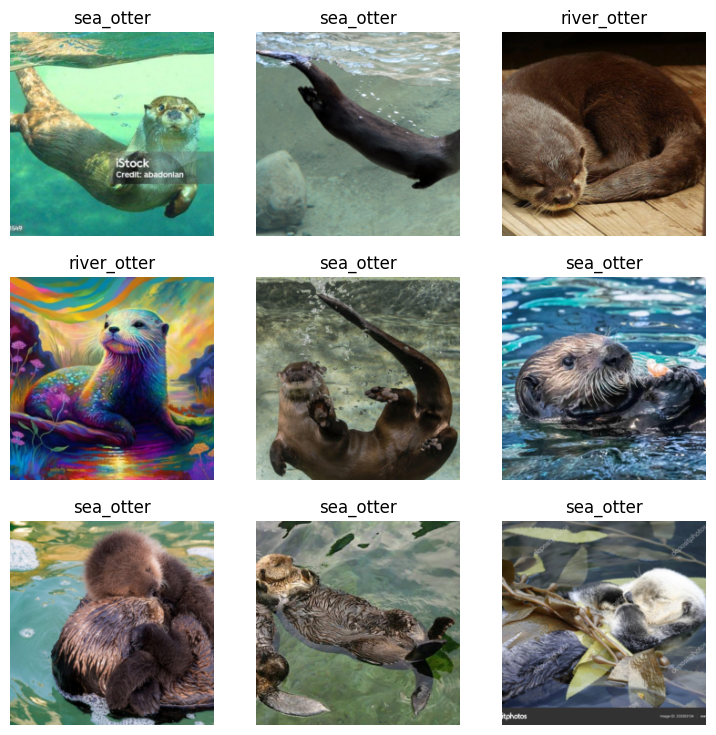

In [5]:
data_loaders.show_batch()

In [6]:
# Note: Images in the above look good, so we can proceed with training.

In [7]:
# Get a base model to use in the transfer learning process.
# base_model = resnet34(weights=ResNet34_Weights.DEFAULT)
# base_model = base_model.to(notebook_device)

In [8]:
# Use the fast.ai Learner class to train the model.
learner = vision_learner(
    dls=data_loaders,
    arch=resnet34,
    loss_func=CrossEntropyLossFlat(),
    metrics=accuracy,
    weights=ResNet34_Weights.DEFAULT,
)

learner.fine_tune(2)

epoch,train_loss,valid_loss,accuracy,time
0,1.030806,0.402138,0.866667,00:08


/home/cpbonnell/projects/ott-or-not/modeling_notebooks/.venv/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


epoch,train_loss,valid_loss,accuracy,time
0,0.433073,0.363657,0.925000,00:07
1,0.323967,0.405830,0.925000,00:08


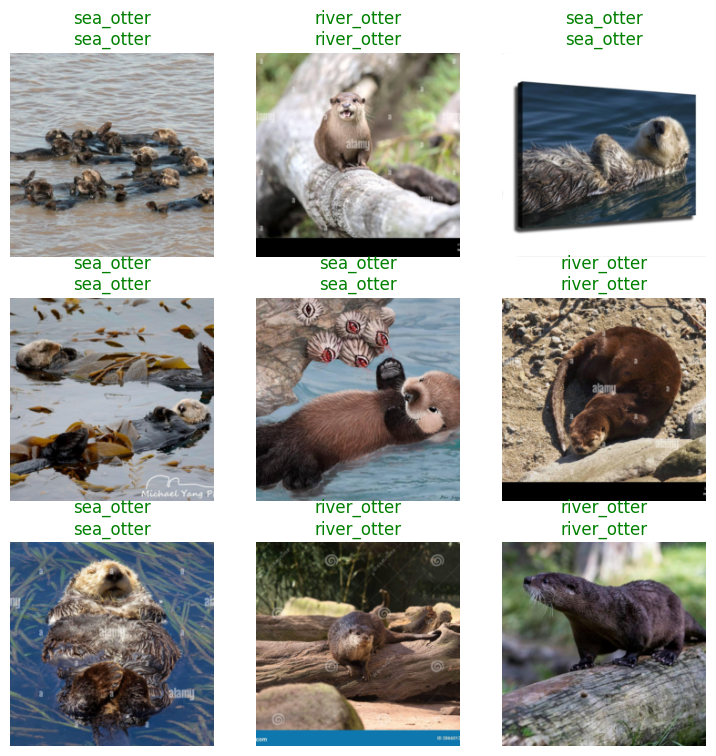

In [9]:
learner.show_results()

In [10]:
interp = ClassificationInterpretation.from_learner(learner)

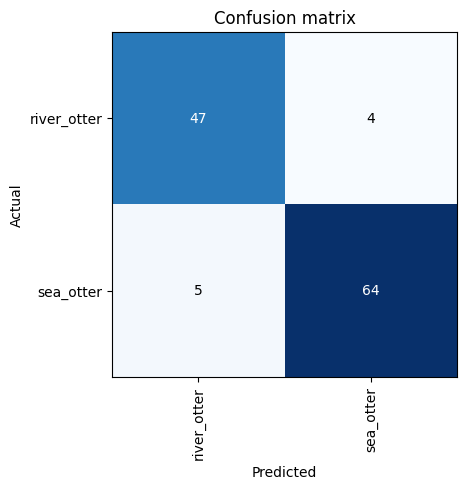

In [11]:
interp.plot_confusion_matrix()

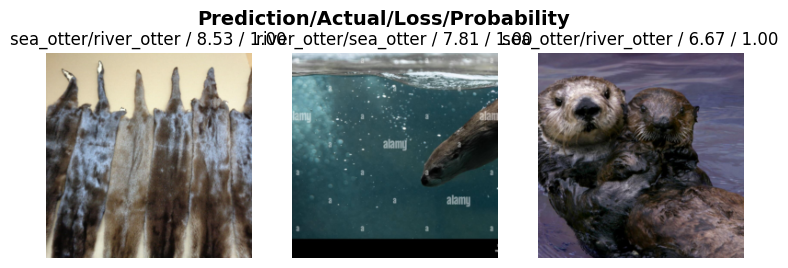

In [13]:
interp.plot_top_losses(k=3, nrows=1)

## Conclusions
The results from this round show incredible accuracy even with just the faulty data we have. Most of the misclassifications counted in the validation set are either of pictures that are not actually otters, or images that the mode correctly classified but were mislabeled in the set (and thus are not actually mistakes).

At this point the next step is to collect image data for all the species we want to predict, and prepare a hand-cleaned validation set so that we can accurately report the real performance of our model.